In [122]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import probplot
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm, probplot, skew
import numpy as np
from sklearn import preprocessing


In [123]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [124]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data


,Total,Percent
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
smoking_history,0,0.0
bmi,0,0.0
HbA1c_level,0,0.0
blood_glucose_level,0,0.0
diabetes,0,0.0


As we can see based off of the fact that we have no null values for any of our columns we do not need to apply any sort of handling of our missing data. In this case if we were to have missing data for age, bmi, HbA1c_level, blood_glucose_level we would take the medium values inside of these columns and input that for the missing values as this is best practice in our case. However just because there is no null values, the smoking history column has a section that says no info

In [125]:
count = (df['smoking_history'] == 'No Info').sum()
print(count)

print(df['smoking_history'].value_counts())
print("Total people with diabetes", df['diabetes'].sum())


diabetes = ((df['diabetes'] == 1) & (df['smoking_history'] == 'No Info')).sum()
diabetes2 = ((df['diabetes'] == 0) & (df['smoking_history'] == 'No Info')).sum()
print(f"Number of 'No info' on smoking histroy with Diabetes: {diabetes}")
print(f"Number of 'No info' on smoking histroy without Diabetes: {diabetes2}")

35816
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64
Total people with diabetes 8500
Number of 'No info' on smoking histroy with Diabetes: 1454
Number of 'No info' on smoking histroy without Diabetes: 34362


In [126]:
rows = len(df)

drop_percent = count/rows
drop_percent

np.float64(0.35816)

As can be seen by the 2 previous cells, the number of people that have diabetes with no info on their smoking history is about 17 percent of our total population of those that have diabetes. This brings into question what we should do with this column that has no info. 

<function matplotlib.pyplot.show(close=None, block=None)>

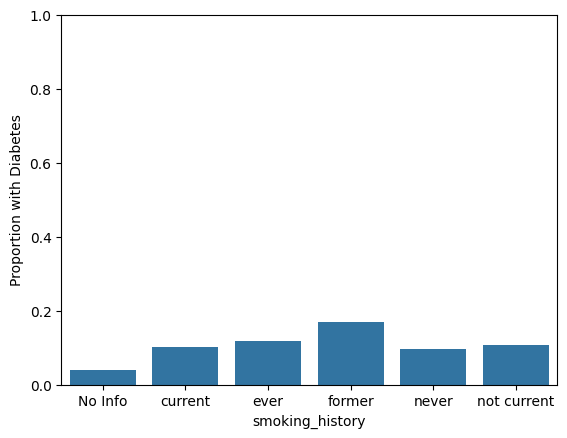

In [127]:
grouped = df.groupby('smoking_history')['diabetes'].mean().reset_index()

sns.barplot(x='smoking_history', y='diabetes', data=grouped)
plt.ylabel('Proportion with Diabetes')
plt.ylim(0,1)
plt.show

The graph shows the perentages of people with diabetes in correaltion to smoking history. As you can see 0 (no info) is far and away the lowest percentage of people with diabetes, but make up almost half our dataset. It makes sense to drop those rows and focus on the variables that effect our model in determining if a person has diabetes. 

In [128]:
#df.drop(df[df['smoking_history'] == 'No Info'].index, inplace=True)
#df

In [129]:
print("Number of 'No info' for smokers: ", (df['smoking_history'] == "No Info").sum())

Number of 'No info' for smokers:  35816


Here we can create a label encoder to encode all of our categorical data. This will correspond to never smoking = 4, former smoker = 3, not current smoker = 2, current smoker = 1, no info = 0

In [130]:
le = LabelEncoder()
df["smoking_encoded"] = le.fit_transform(df["smoking_history"])
encoded = le.fit_transform(df['smoking_encoded'])
df.head(15)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,Female,80.0,0,1,never,25.19,6.6,140,0,4
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,4
3,Female,36.0,0,0,current,23.45,5.0,155,0,1
4,Male,76.0,1,1,current,20.14,4.8,155,0,1
5,Female,20.0,0,0,never,27.32,6.6,85,0,4
6,Female,44.0,0,0,never,19.31,6.5,200,1,4
7,Female,79.0,0,0,No Info,23.86,5.7,85,0,0
8,Male,42.0,0,0,never,33.64,4.8,145,0,4
9,Female,32.0,0,0,never,27.32,5.0,100,0,4


We can also get rid of the gender category and dummy encode it, knowing that if we have 

In [131]:
df = pd.get_dummies(df, columns=["gender"], drop_first=True)
df.drop(columns=["gender_Other"], inplace=True)
df

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,4,False
1,54.0,0,0,No Info,27.32,6.6,80,0,0,False
2,28.0,0,0,never,27.32,5.7,158,0,4,True
3,36.0,0,0,current,23.45,5.0,155,0,1,False
4,76.0,1,1,current,20.14,4.8,155,0,1,True
...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,No Info,27.32,6.2,90,0,0,False
99996,2.0,0,0,No Info,17.37,6.5,100,0,0,False
99997,66.0,0,0,former,27.83,5.7,155,0,3,True
99998,24.0,0,0,never,35.42,4.0,100,0,4,False


The cell below demonstrates the lack of homogeniouty between our different categorical elements, with smoking_history having a ~.546 mode frequency, showing this could be a viable comparison for our model.

In [132]:
print("Categorical Columns Mode Frequency")
cat_columns = df.select_dtypes(include=["object"]).columns
mode_freq_df = pd.DataFrame(columns=["column_name", "mode_frequency"])
mode_freq_df.head
for col in cat_columns:
    mode_value = df[col].mode().iat[0]
    mode_freq = (df[col] == mode_value).mean()
# create a new row at the next integer index
mode_freq_df.loc[len(mode_freq_df)] = [col, mode_freq]
print(mode_freq_df.sort_values("mode_frequency", ascending=False).head(10))

Categorical Columns Mode Frequency
       column_name  mode_frequency
0  smoking_history         0.35816


---
Handling Outliers

In [133]:
df.head()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,4,False
1,54.0,0,0,No Info,27.32,6.6,80,0,0,False
2,28.0,0,0,never,27.32,5.7,158,0,4,True
3,36.0,0,0,current,23.45,5.0,155,0,1,False
4,76.0,1,1,current,20.14,4.8,155,0,1,True


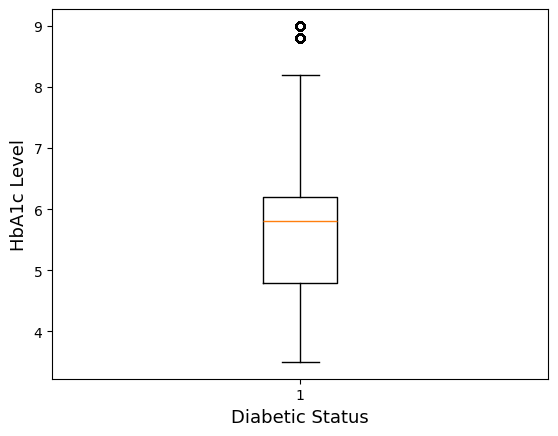

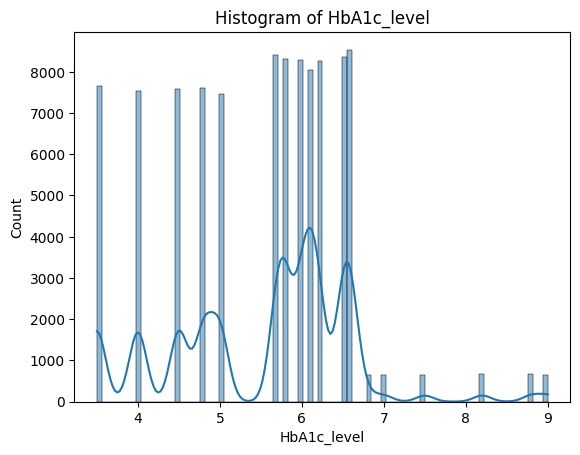

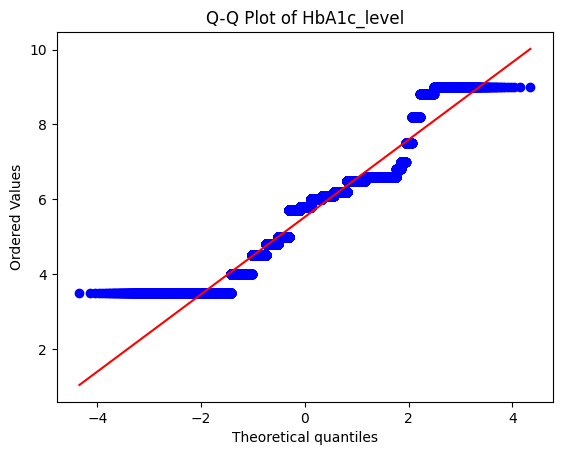

In [134]:
fig, ax = plt.subplots()
ax.boxplot(x=df["HbA1c_level"])
plt.ylabel("HbA1c Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["HbA1c_level"], kde=True)
plt.title(f'Histogram of HbA1c_level')
plt.show()
probplot(df["HbA1c_level"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of HbA1c_level')
plt.show()

As this data does have some outliers we are not going to get rid of those as they may be clinically significant. Through research we found that high HbA1c is often associated with diabetes, so we do not want to to get rid of this and lose accuracy of our model. However we will need to preform normalization techniques on the series as shown by the histrogram the data is no where near normal. This can also be seen by the qq plot as our data does not stick to the red line. We will need to preform these normalization techniques to ensure that we can use logistic regression to its most potential, as this is a requirement for logistic regression to work accuratly. 



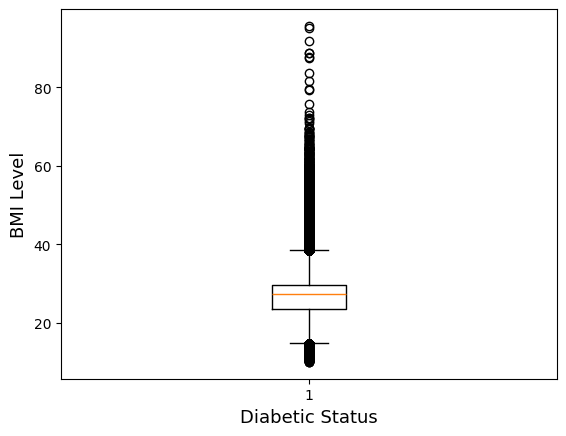

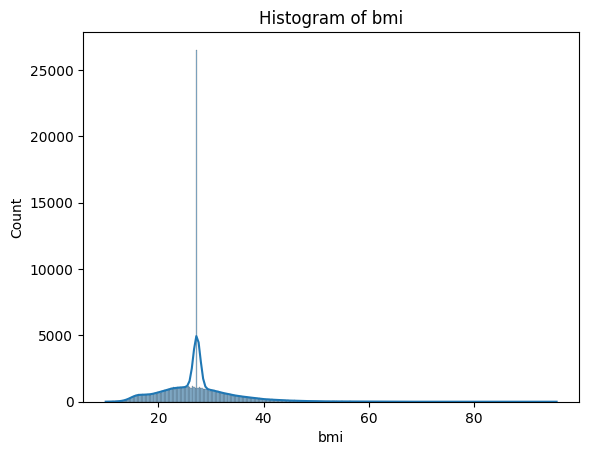

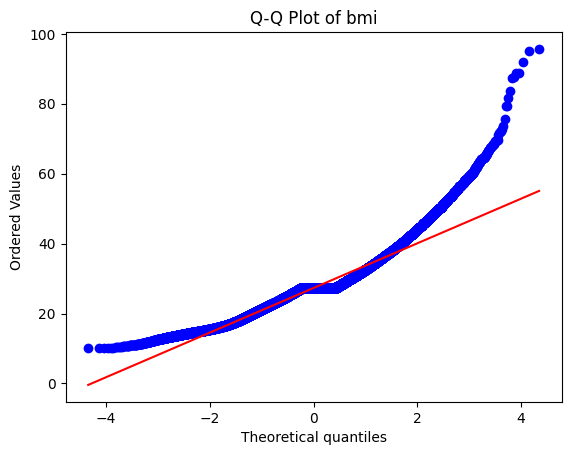

In [135]:
fig, ax = plt.subplots()
ax.boxplot(x=df["bmi"])
plt.ylabel("BMI Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["bmi"], kde=True)
plt.title(f'Histogram of bmi')
plt.show()
probplot(df["bmi"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of bmi')
plt.show()

As can be seen by this graph there are a lot of outliers. We do not want to get rid of this data as these are likely valid and meaningful, especially in a medical context. Removing them would reduce the model's ability to identify high risk individuals. As seen by the histogram normalization will need to be preformed on this series as to complete logistic regression the data must be normal. We can also see how our data is unormal through the qq plot of BMI as it is not fully along the red line, especially at the end where it starts to curve up which signifies heavy outliers. 

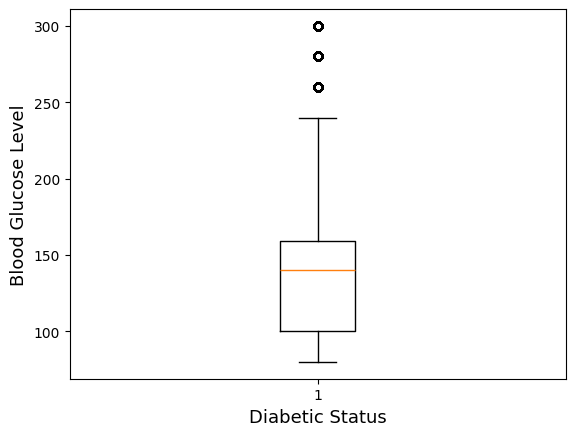

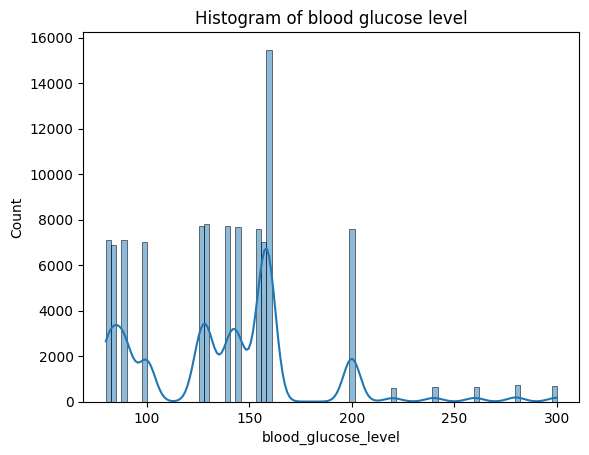

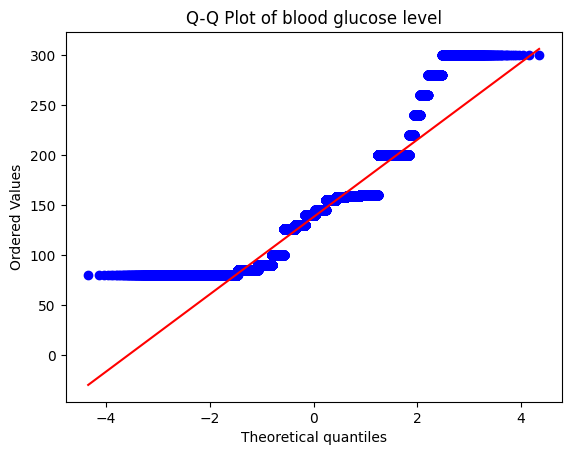

In [136]:

fig, ax = plt.subplots()
ax.boxplot(x=df["blood_glucose_level"])
plt.ylabel("Blood Glucose Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["blood_glucose_level"], kde=True)
plt.title(f'Histogram of blood glucose level')
plt.show()
probplot(df["blood_glucose_level"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of blood glucose level')
plt.show()

As blood gluscose level does have some outliers we are not going to get rid of those as higher blood glucose levels could lead to a higher chance of diabetes. However as can be obsereved by the histogram of blood glucose level, the sereis is no where near normal, so we will have to normalize this series as well in order to complete logisitc regression, The qq plot also gives a more understandable graph to show how far our data is from being normal as it rarely is toucing the red line that indicats a normal distribution. 

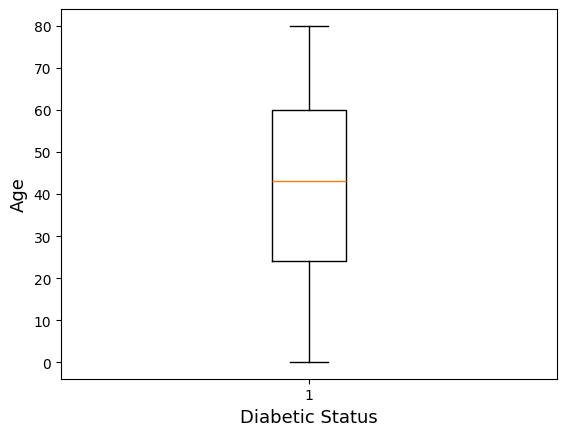

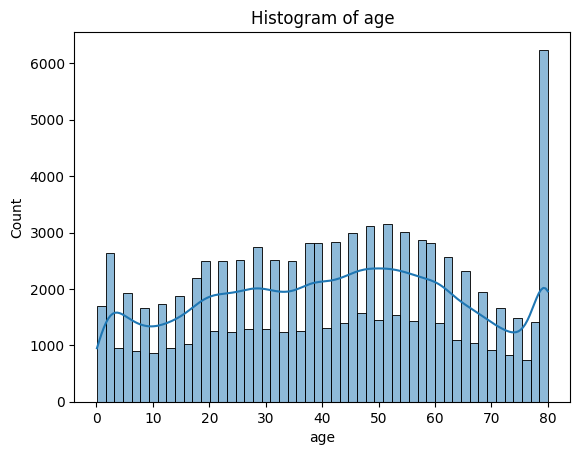

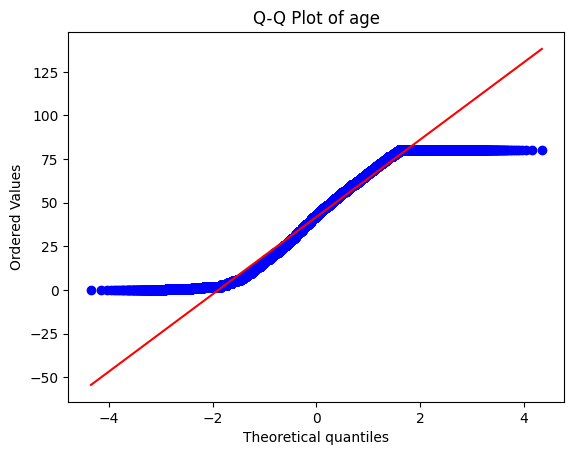

In [137]:
fig, ax = plt.subplots()
ax.boxplot(x=df["age"])
plt.ylabel("Age", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["age"], kde=True)
plt.title(f'Histogram of age')
plt.show()
probplot(df["age"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of age')
plt.show()

As can be seen by the boxplot this series does not have any outliers, and this is propably the most normal data that we have seen so far. However we will still apply normalization techniques to this series to ensure that logisitic regression works as best as possible. 

In [138]:
num_cols = ['age', 'HbA1c_level', 'blood_glucose_level', 'bmi']
#x_array = df[num_cols].values  # shape (n_samples, n_features)
# Normalize column-wise (axis=0 ensures each column is normalized independently)
#normalized_arr = preprocessing.normalize(x_array, axis=0)

# Assign back to DataFrame (overwrite original columns)
#df[num_cols] = pd.DataFrame(normalized_arr, columns=num_cols)
from sklearn.preprocessing import StandardScaler, Normalizer

#scaler = StandardScaler()
# scaler = Normalizer()
#df[num_cols] = scaler.fit_transform(df[num_cols])
#df["BMI_normalized"] = np.log1p(df["bmi"])
#sns.histplot(df["BMI_normalized"], kde=True)
#plt.title(f'Histogram of BMI_normalized')
#plt.show()

#plt.figure()

#probplot(df["BMI_normalized"], dist="norm", plot=plt)
#plt.title(f'Q-Q Plot of BMI_normalized')
#plt.grid(True)

# plt.show()

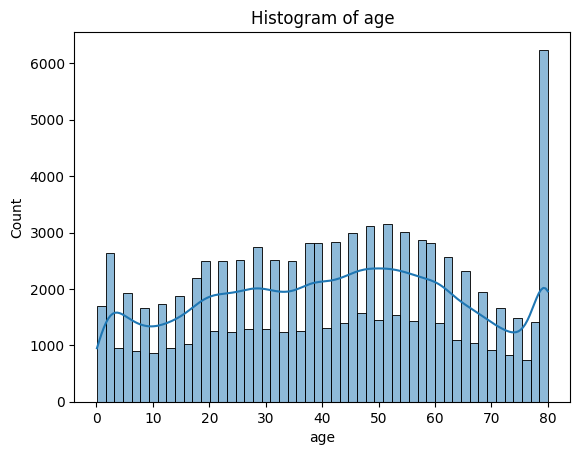

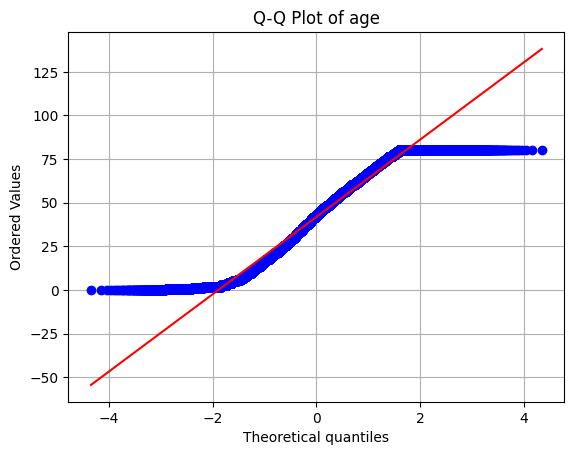

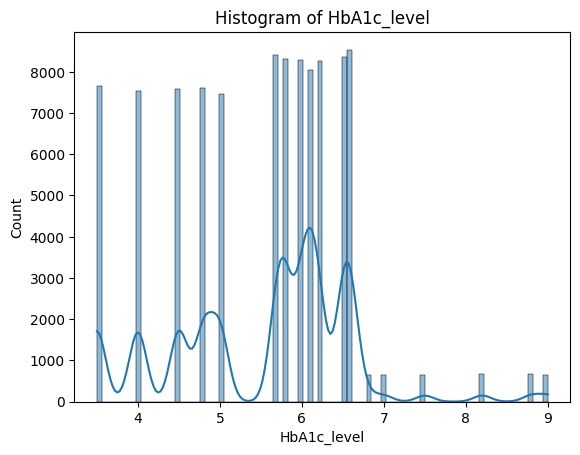

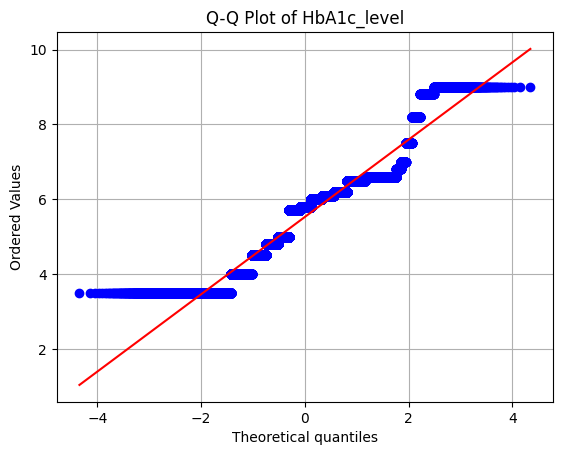

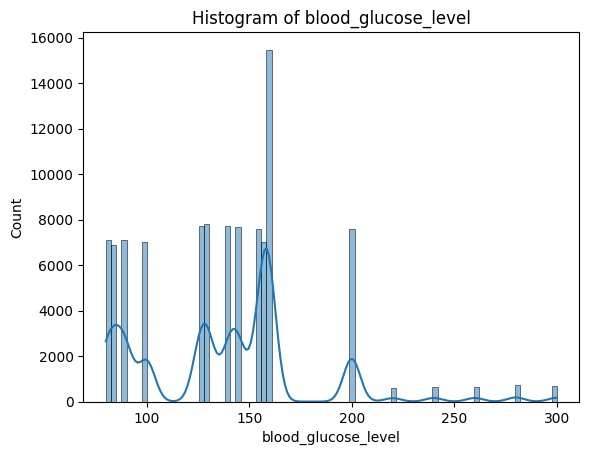

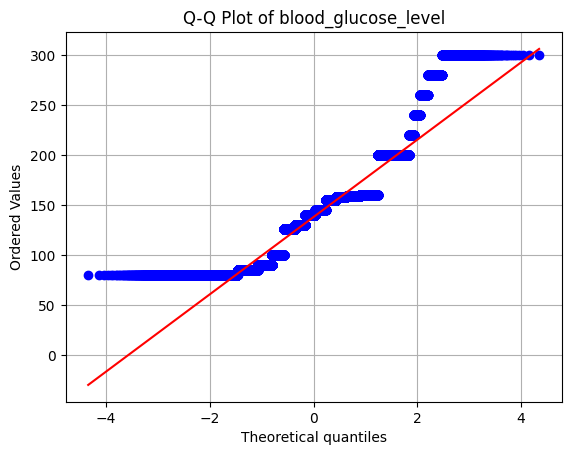

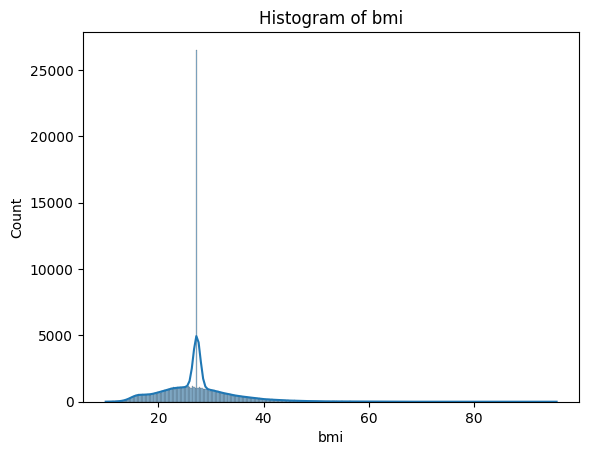

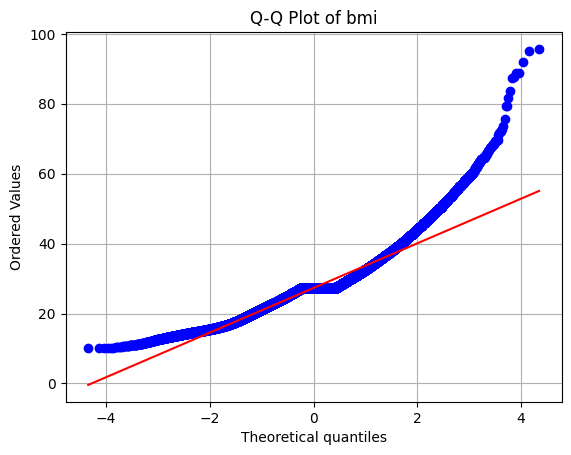

In [139]:
for col in num_cols:
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()
    
    plt.figure()

    probplot(df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')
    plt.grid(True)

    plt.show()

In [140]:
# Identify variable types
categorical_vars = ['gender_Male', 'smoking_history']
ordinal_vars = ['hypertension', 'heart_disease']
numerical_vars = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
target_var = 'diabetes'

print("Categorical Variables:", categorical_vars)
print("Ordinal Variables:", ordinal_vars)
print("Numerical Variables:", numerical_vars)
print("Target Variable (Dependent):", target_var)

Categorical Variables: ['gender_Male', 'smoking_history']
Ordinal Variables: ['hypertension', 'heart_disease']
Numerical Variables: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Target Variable (Dependent): diabetes


While we have encoded the variables gender and smoking_history, they are still categorical variables but we will just represent them with numbers.

In [141]:
# Measures of centrality and distribution
df[numerical_vars].describe()

,age,bmi,HbA1c_level,blood_glucose_level
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,27.320767,5.527507,138.058060
std,22.516840,6.636783,1.070672,40.708136
min,0.080000,10.010000,3.500000,80.000000
25%,24.000000,23.630000,4.800000,100.000000
50%,43.000000,27.320000,5.800000,140.000000
75%,60.000000,29.580000,6.200000,159.000000
max,80.000000,95.690000,9.000000,300.000000


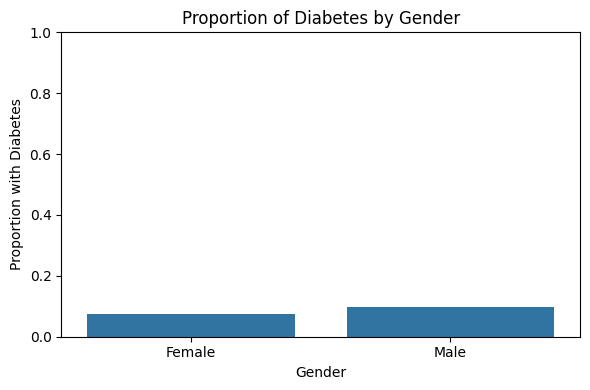

In [142]:
# print(df)
# for col in categorical_vars:
#     plt.figure(figsize=(6, 4))
#     sns.countplot(x=col, hue=target_var, data=df)
#     plt.title(f'Diabetes Distribution across {col}')
#     plt.tight_layout()
#     plt.show()
# Compute diabetes rate within each gender group
gender_diabetes_rate = df.groupby('gender_Male')['diabetes'].mean().reset_index()

# Plot as bar plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x='gender_Male', y='diabetes', data=gender_diabetes_rate)
plt.title('Proportion of Diabetes by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.xticks([0, 1], ['Female', 'Male'])  # Better labels
plt.tight_layout()
plt.show()

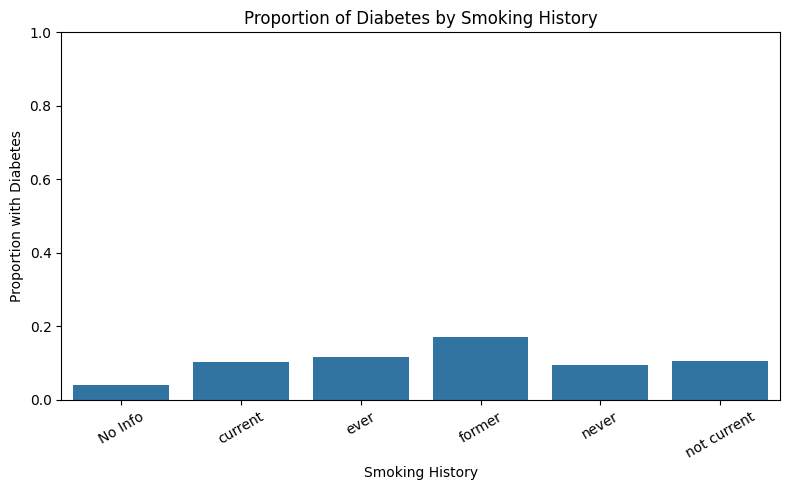

In [143]:
# Calculate proportion of diabetes in each smoking category
smoking_diabetes_rate = df.groupby('smoking_history')['diabetes'].mean().reset_index()

# Plot the results
plt.figure(figsize=(8, 5))
sns.barplot(x='smoking_history', y='diabetes', data=smoking_diabetes_rate)
plt.title('Proportion of Diabetes by Smoking History')
plt.xlabel('Smoking History')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

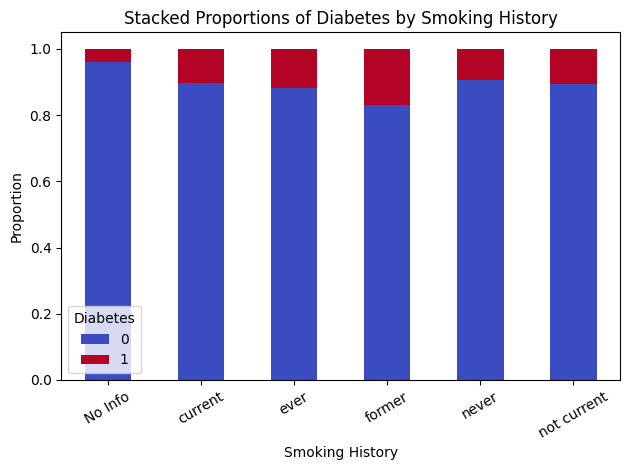

In [144]:
smoking_crosstab = pd.crosstab(df['smoking_history'], df['diabetes'], normalize='index')
smoking_crosstab.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Stacked Proportions of Diabetes by Smoking History')
plt.ylabel('Proportion')
plt.xlabel('Smoking History')
plt.legend(title='Diabetes')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

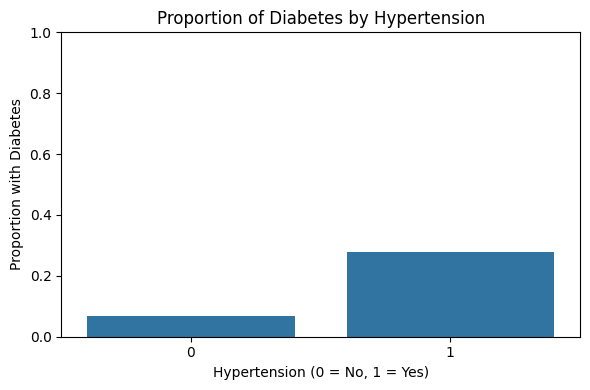

In [145]:
# Proportion of diabetes within hypertension groups
htn_rate = df.groupby('hypertension')['diabetes'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='hypertension', y='diabetes', data=htn_rate)
plt.title('Proportion of Diabetes by Hypertension')
plt.xlabel('Hypertension (0 = No, 1 = Yes)')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

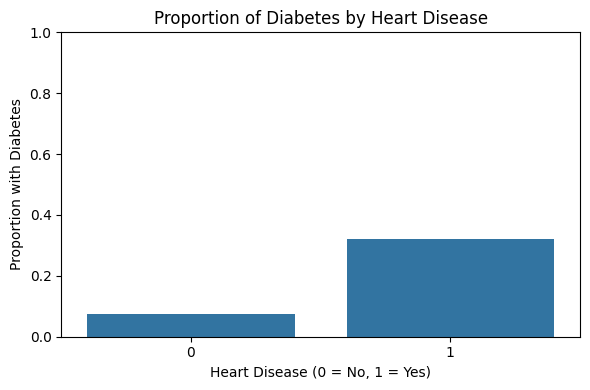

In [146]:
heart_rate = df.groupby('heart_disease')['diabetes'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='heart_disease', y='diabetes', data=heart_rate)
plt.title('Proportion of Diabetes by Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

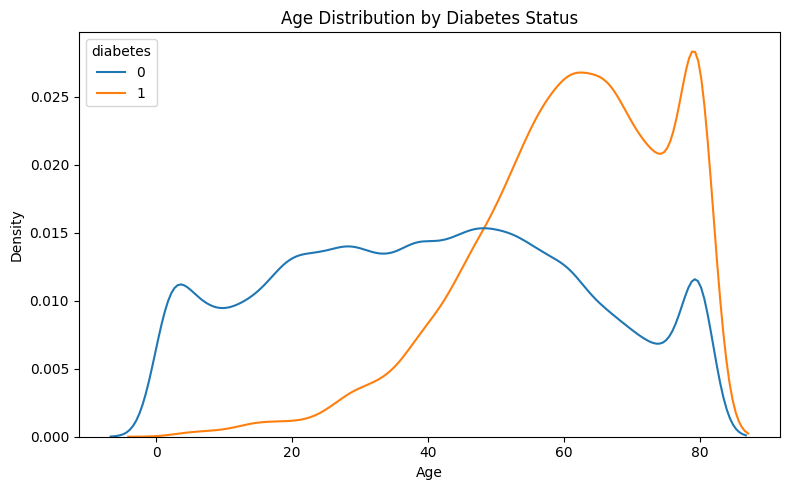

In [147]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='age', hue='diabetes', common_norm=False)
plt.title('Age Distribution by Diabetes Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

This graph shows how age is positively correlated with diabetes. The diabetic population tends to be older, while younger individuals are more likely to be non-diabetic. This pattern supports our research that the risk of developing diabetes increases with age.

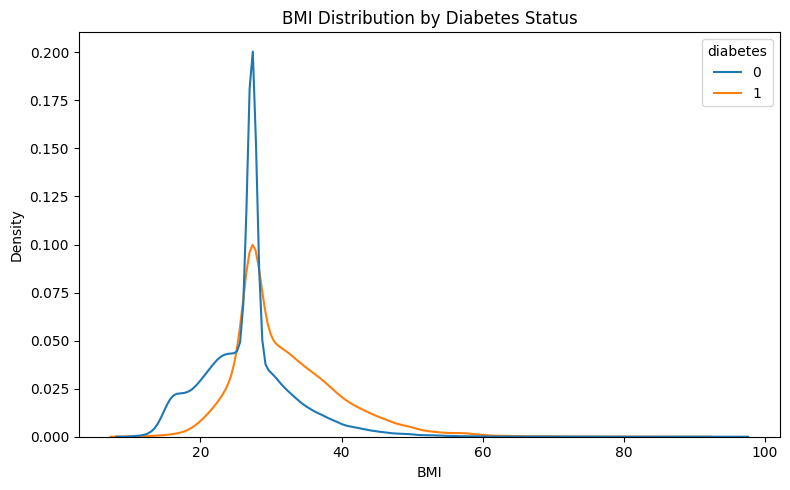

In [148]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='bmi', hue='diabetes', common_norm=False)
plt.title('BMI Distribution by Diabetes Status')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

While both groups share similar median BMI values, individuals with diabetes exhibit more variance and a slight shift toward higher BMI values. This suggests a potential, though not dominant, relationship between higher BMI and diabetes risk.

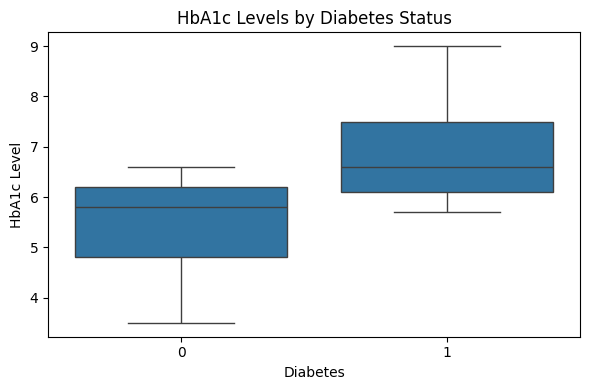

In [149]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c Levels by Diabetes Status')
plt.xlabel('Diabetes')
plt.ylabel('HbA1c Level')
plt.tight_layout()
plt.show()


There is a strong positive association between elevated HbA1c levels and diabetes. Individuals diagnosed with diabetes tend to have significantly higher HbA1c levels, which aligns with research that we have done about HbA1c levels and diabetes. This makes it a reliable indicator for distinguishing diabetic status.

# I asked chat to make this and I do not really know what it means but feel free to describe it

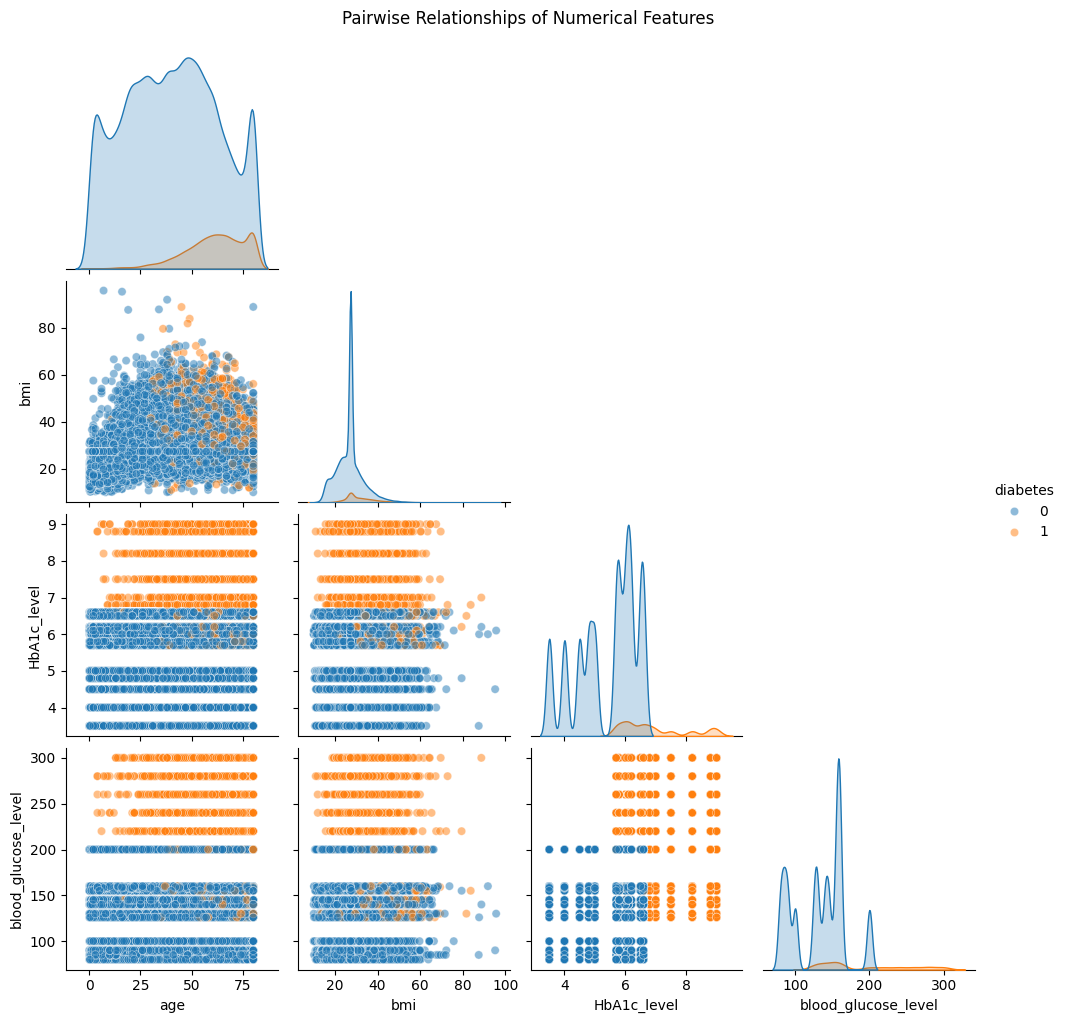

In [150]:
sns.pairplot(df, vars=['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'], hue='diabetes', corner=True, plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Relationships of Numerical Features', y=1.02)
plt.show()

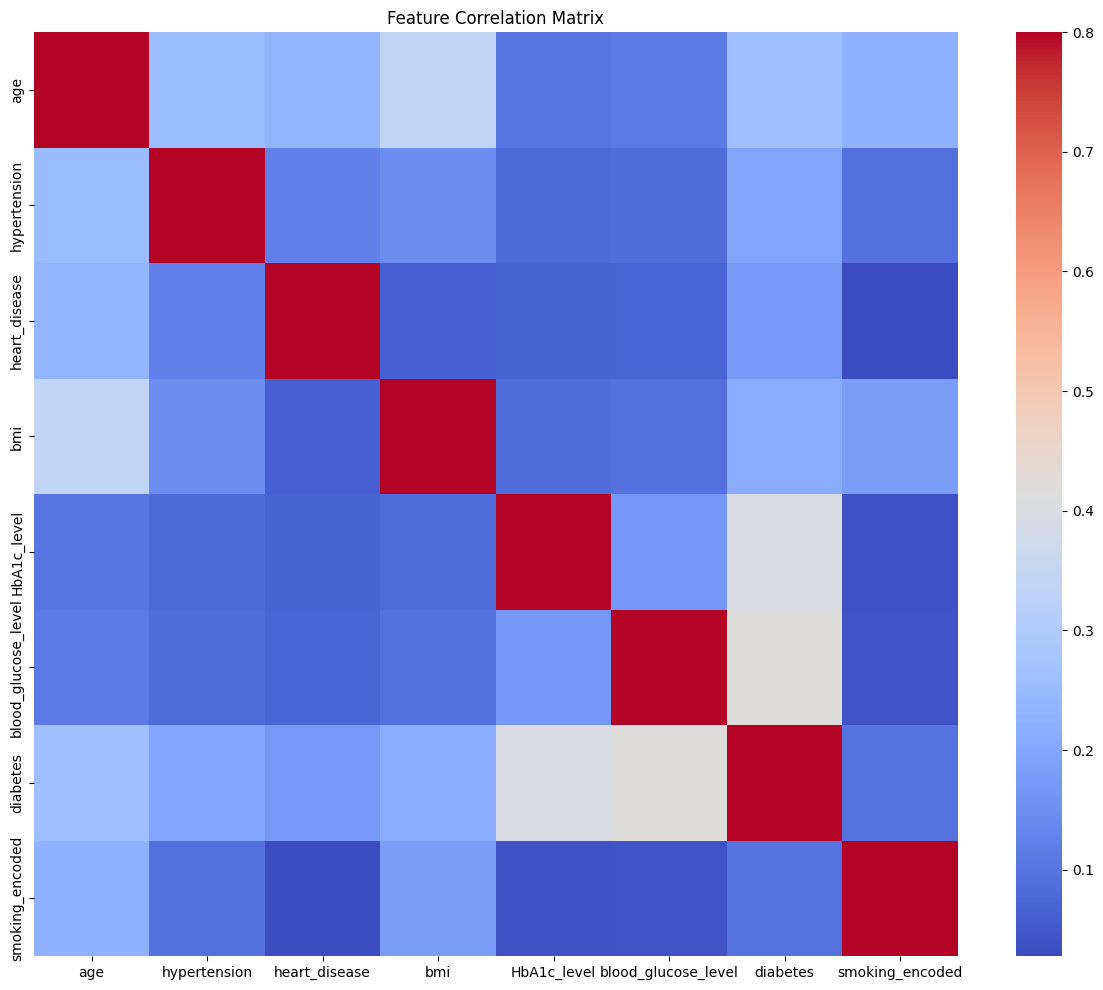

In [151]:
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.title('Feature Correlation')
# plt.show()
# df.head(10)
# df = df.drop(columns=['bmi'])
numeric_df = df.select_dtypes(include=[np.number])
corrmat = numeric_df.corr()
# Plot
plt.figure(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.8, square=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

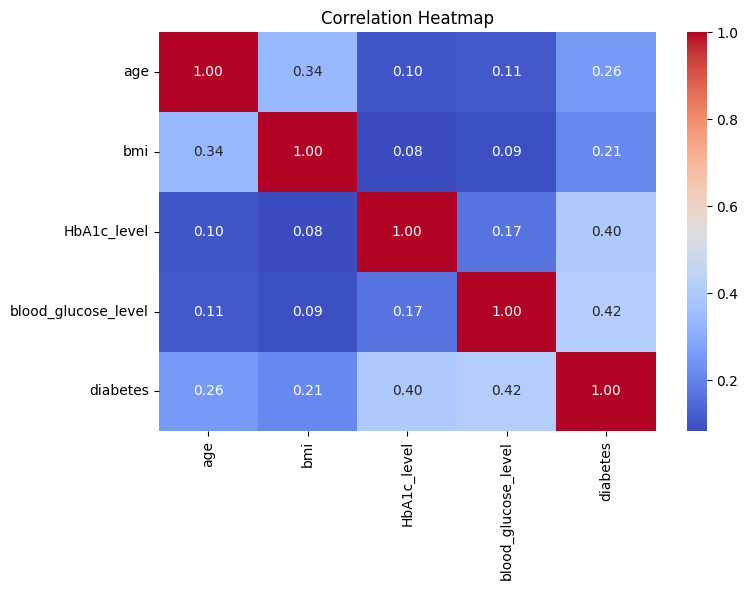

In [152]:
corr_matrix = df[numerical_vars + [target_var]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

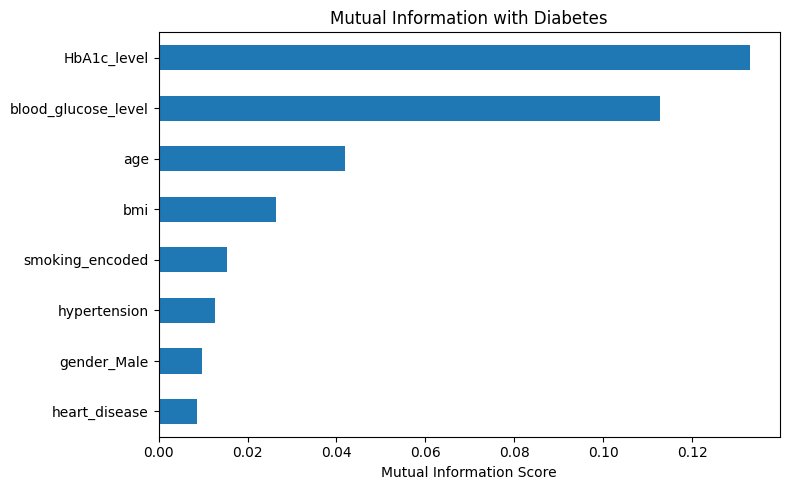

In [153]:
feature_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level',
                'hypertension', 'heart_disease', 'smoking_encoded', 'gender_Male']
X = df[feature_cols]
y = df['diabetes']

# Calculate Mutual Information
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

mi_scores = mutual_info_classif(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=feature_cols).sort_values()

# Plot Mutual Information
plt.figure(figsize=(8, 5))
mi_series.plot(kind='barh', title='Mutual Information with Diabetes')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.show()

In [154]:
# from sklearn.ensemble import GradientBoostingClassifier

# # Train model
# model = GradientBoostingClassifier(random_state=0)
# model.fit(X, y)

# # Get feature importances
# feature_importance = pd.Series(model.feature_importances_, index=feature_cols).sort_values()

# # Plot Feature Importance
# plt.figure(figsize=(8, 5))
# feature_importance.plot(kind='barh', title='Gradient Boosting Feature Importance')
# plt.xlabel('Importance Score')
# plt.tight_layout()
# plt.show()

This project uses a supervised learning approach because the goal is to predict a known outcome: whether or not an individual has diabetes. Supervised learning is appropriate when the target variable is labeled, which is the case here with the diabetes column containing binary values (0 for non-diabetic, 1 for diabetic). Each instance in the dataset includes both a label and a set of features, making this a classic binary classification problem.The dependent variable in this dataset is diabetes, which represents the outcome we are trying to predict. All other variables are considered independent features. These include numerical features like age, bmi, HbA1c_level, and blood_glucose_level; binary indicators like hypertension and heart_disease; and encoded categorical variables such as gender_Male and smoking_encoded. These independent variables are used as inputs to train classification models to learn patterns and relationships that can help with finding out if someone has diabetes or not.

To evaluate the performance of the classification models, we chose to look at accuracy, precision, recall, F1 score, and ROC AUC. Accuracy provides a general sense of how often the model predicts correctly, while precision focuses on reducing false positives, which is useful when misclassifying healthy individuals. Recall is particularly critical in healthcare applications, where failing to detect someone with diabetes (a false negative) can have serious consequences. The F1 score uses both precision and recall, offering a single metric that reflects the trade off between them. Lastly, ROC AUC measures the model’s ability to rank positive cases higher than negative ones across all thresholds, making it an effective metric for overall model discrimination.

In [155]:
df

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,4,False
1,54.0,0,0,No Info,27.32,6.6,80,0,0,False
2,28.0,0,0,never,27.32,5.7,158,0,4,True
3,36.0,0,0,current,23.45,5.0,155,0,1,False
4,76.0,1,1,current,20.14,4.8,155,0,1,True
...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,No Info,27.32,6.2,90,0,0,False
99996,2.0,0,0,No Info,17.37,6.5,100,0,0,False
99997,66.0,0,0,former,27.83,5.7,155,0,3,True
99998,24.0,0,0,never,35.42,4.0,100,0,4,False


In [156]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score



# # Create a list of models to test
# models_to_test = {
#     "Logistic Regression": LogisticRegression(max_iter=1000),
#     "Random Forest": RandomForestClassifier(random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(random_state=42),
#     "SVM (RBF Kernel)": SVC(probability=True, random_state=42),
#     "Naive Bayes": GaussianNB()
# }

# Define feature columns
feature_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level',
                'hypertension', 'heart_disease', 'smoking_encoded', 'gender_Male']
X= df[feature_cols]
y = df['diabetes']

# # Prepare to store results
# performance_comparison = []

# # Train/test split (same for both settings)
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, stratify=y, random_state=42)

# # Evaluate each model on both raw and normalized data
# for name, model in models_to_test.items():
#     # 1. Raw data
#     model.fit(X_train_raw, y_train)
#     y_pred_raw = model.predict(X_test_raw)
#     y_proba_raw = model.predict_proba(X_test_raw)[:, 1] if hasattr(model, "predict_proba") else None

#     performance_comparison.append({
#         "Model": name,
#         "Normalization": "Raw",
#         "Accuracy": accuracy_score(y_test, y_pred_raw),
#         "Precision": precision_score(y_test, y_pred_raw, zero_division=0),
#         "Recall": recall_score(y_test, y_pred_raw, zero_division=0),
#         "F1 Score": f1_score(y_test, y_pred_raw, zero_division=0),
#         "ROC AUC": roc_auc_score(y_test, y_proba_raw) if y_proba_raw is not None else None
#     })

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model_with_scaler(model, scaler, X, y, cv_folds=5):
    if scaler:
        pipeline = make_pipeline(scaler, model)
    else:
        pipeline = model

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
    y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall": recall_score(y, y_pred, zero_division=0),
        "F1 Score": f1_score(y, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y, y_proba) if y_proba is not None else None
    }

    return metrics

In [157]:
raw_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    #"SVM (RBF Kernel)": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []

# Evaluate each model on raw data
print("Model Performance (Raw Data):")
for model_name, model in raw_models.items():
    metrics = evaluate_model_with_scaler(model, scaler=None, X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Raw",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance (Raw Data):



Logistic Regression:
  Accuracy: 0.9601
  Precision: 0.8671
  Recall: 0.6272
  F1 Score: 0.7279
  ROC AUC: 0.9613

Random Forest:
  Accuracy: 0.9699
  Precision: 0.9455
  Recall: 0.6854
  F1 Score: 0.7947
  ROC AUC: 0.9637

Gradient Boosting:
  Accuracy: 0.9720
  Precision: 0.9845
  Recall: 0.6812
  F1 Score: 0.8052
  ROC AUC: 0.9791

Naive Bayes:
  Accuracy: 0.9034
  Precision: 0.4523
  Recall: 0.6478
  F1 Score: 0.5326
  ROC AUC: 0.9222


In [158]:
scaledModels = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
   # "SVM (RBF Kernel)": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model on raw data
print("Model Performance Standard Scaler:")
for model_name, model in scaledModels.items():
    metrics = evaluate_model_with_scaler(model, scaler=StandardScaler(), X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Standard Scaler",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance Standard Scaler:

Logistic Regression:
  Accuracy: 0.9602
  Precision: 0.8672
  Recall: 0.6276
  F1 Score: 0.7282
  ROC AUC: 0.9613

Random Forest:
  Accuracy: 0.9699
  Precision: 0.9455
  Recall: 0.6854
  F1 Score: 0.7947
  ROC AUC: 0.9637

Gradient Boosting:
  Accuracy: 0.9720
  Precision: 0.9845
  Recall: 0.6812
  F1 Score: 0.8052
  ROC AUC: 0.9791

Naive Bayes:
  Accuracy: 0.9034
  Precision: 0.4523
  Recall: 0.6478
  F1 Score: 0.5326
  ROC AUC: 0.9222


In [159]:
normalizedModels = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    #"SVM (RBF Kernel)": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model on raw data
print("Model Performance Normalized Data:")
for model_name, model in scaledModels.items():
    metrics = evaluate_model_with_scaler(model, scaler=Normalizer(), X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Normalized",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance Normalized Data:

Logistic Regression:
  Accuracy: 0.9150
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7446

Random Forest:
  Accuracy: 0.9555
  Precision: 0.8989
  Recall: 0.5365
  F1 Score: 0.6719
  ROC AUC: 0.9399

Gradient Boosting:
  Accuracy: 0.9483
  Precision: 0.9497
  Recall: 0.4133
  F1 Score: 0.5759
  ROC AUC: 0.9320

Naive Bayes:
  Accuracy: 0.8791
  Precision: 0.2892
  Recall: 0.2895
  F1 Score: 0.2894
  ROC AUC: 0.7793


In [160]:
robustModels = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    #"SVM (RBF Kernel)": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model on raw data
print("Model Performance Robust scaler:")
for model_name, model in scaledModels.items():
    metrics = evaluate_model_with_scaler(model, scaler=RobustScaler(), X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Robust",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance Robust scaler:

Logistic Regression:
  Accuracy: 0.9602
  Precision: 0.8681
  Recall: 0.6272
  F1 Score: 0.7282
  ROC AUC: 0.9613

Random Forest:
  Accuracy: 0.9699
  Precision: 0.9452
  Recall: 0.6858
  F1 Score: 0.7948
  ROC AUC: 0.9636

Gradient Boosting:
  Accuracy: 0.9720
  Precision: 0.9845
  Recall: 0.6812
  F1 Score: 0.8052
  ROC AUC: 0.9791

Naive Bayes:
  Accuracy: 0.9034
  Precision: 0.4523
  Recall: 0.6478
  F1 Score: 0.5326
  ROC AUC: 0.9222


In [161]:
# # 2. Standard Scaled data
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', model)
# ])
# pipeline.fit(X_train_raw, y_train)
# y_pred_scaled = pipeline.predict(X_test_raw)
# y_proba_scaled = pipeline.predict_proba(X_test_raw)[:, 1] if hasattr(pipeline.named_steps['classifier'], "predict_proba") else None

# performance_comparison.append({
#     "Model": name,
#     "Normalization": "StandardScaler",
#     "Accuracy": accuracy_score(y_test, y_pred_scaled),
#     "Precision": precision_score(y_test, y_pred_scaled, zero_division=0),
#     "Recall": recall_score(y_test, y_pred_scaled, zero_division=0),
#     "F1 Score": f1_score(y_test, y_pred_scaled, zero_division=0),
#     "ROC AUC": roc_auc_score(y_test, y_proba_scaled) if y_proba_scaled is not None else None
# })


In [162]:
## 3. Normalizer
#pipeline = Pipeline([
#     ('scaler', Normalizer()),
#     ('classifier', model)
# ])
#pipeline.fit(X_train_raw, y_train)
#y_pred_scaled = pipeline.predict(X_test_raw)
#y_proba_scaled = pipeline.predict_proba(X_test_raw)[:, 1] if hasattr(pipeline.named_steps['classifier'], "predict_proba") else None

#performance_comparison.append({
#      "Model": name,
#     "Normalization": "Normalizer",
#     "Accuracy": accuracy_score(y_test, y_pred_scaled),
#     "Precision": precision_score(y_test, y_pred_scaled, zero_division=0),
#     "Recall": recall_score(y_test, y_pred_scaled, zero_division=0),
#     "F1 Score": f1_score(y_test, y_pred_scaled, zero_division=0),
#     "ROC AUC": roc_auc_score(y_test, y_proba_scaled) if y_proba_scaled is not None else None
#})

# # Compile and show results
#performance_df = pd.DataFrame(performance_comparison)

In [163]:
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Normalized vs Raw Model Comparison", dataframe=performance_df)

ModuleNotFoundError: No module named 'ace_tools_open'

In [164]:
feature_df = df[['age',
'bmi', 
'HbA1c_level',
'blood_glucose_level',
'hypertension',
'heart_disease',
'smoking_encoded',
'gender_Male']]

In [165]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(feature_df)

scaled_df = pd.DataFrame(scaled_data, columns=feature_df.columns)
scaled_df

,age,bmi,HbA1c_level,blood_glucose_level,hypertension,heart_disease,smoking_encoded,gender_Male
0,1.692704,-0.321056,1.001706,0.047704,-0.284439,4.936379,0.963327,-0.841046
1,0.538006,-0.000116,1.001706,-1.426210,-0.284439,-0.202578,-1.153468,-0.841046
2,-0.616691,-0.000116,0.161108,0.489878,-0.284439,-0.202578,0.963327,1.188995
3,-0.261399,-0.583232,-0.492690,0.416183,-0.284439,-0.202578,-0.624269,-0.841046
4,1.515058,-1.081970,-0.679490,0.416183,3.515687,4.936379,-0.624269,1.188995
...,...,...,...,...,...,...,...,...
99995,1.692704,-0.000116,0.628107,-1.180558,-0.284439,-0.202578,-1.153468,-0.841046
99996,-1.771388,-1.499343,0.908306,-0.934905,-0.284439,-0.202578,-1.153468,-0.841046
99997,1.070944,0.076729,0.161108,0.416183,-0.284439,-0.202578,0.434128,1.188995
99998,-0.794336,1.220361,-1.426688,-0.934905,-0.284439,-0.202578,0.963327,-0.841046


In [166]:
normalizer = Normalizer()

normal_data = normalizer.fit_transform(scaled_df)

normalized_df = pd.DataFrame(normal_data, columns=scaled_df.columns)

In [177]:
normalizedModels = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    #"SVM (RBF Kernel)": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model on raw data
print("Model Performance Normalized Data:")
for model_name, model in scaledModels.items():
    metrics = evaluate_model_with_scaler(model, scaler=Normalizer(), X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Normalized+Scaled",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

performance_df = pd.DataFrame(results, columns=[
    "Model", "Data Version", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"
])

Model Performance Normalized Data:

Logistic Regression:
  Accuracy: 0.9150
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7446

Random Forest:
  Accuracy: 0.9555
  Precision: 0.8989
  Recall: 0.5365
  F1 Score: 0.6719
  ROC AUC: 0.9399

Gradient Boosting:
  Accuracy: 0.9483
  Precision: 0.9497
  Recall: 0.4133
  F1 Score: 0.5759
  ROC AUC: 0.9320

Naive Bayes:
  Accuracy: 0.8791
  Precision: 0.2892
  Recall: 0.2895
  F1 Score: 0.2894
  ROC AUC: 0.7793


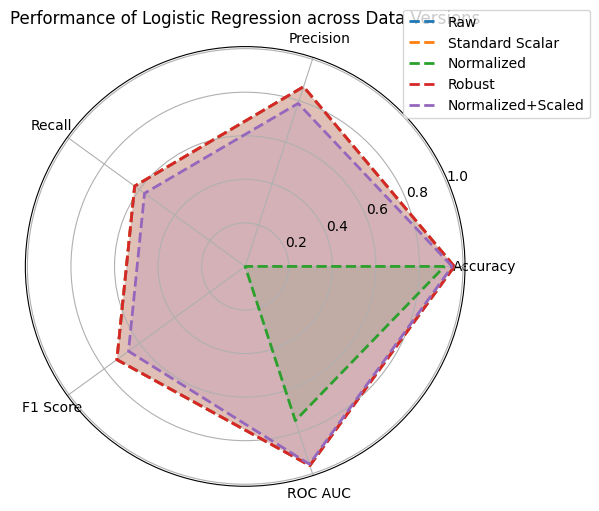

In [ ]:
model_name = "Logistic Regression"
df_subset = performance_df[performance_df["Model"] == model_name]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for version in df_subset["Data Version"].unique():
    row = df_subset[df_subset["Data Version"] == version][labels].values.flatten().tolist()
    row += row[:1]
    ax.plot(angles, row, label=version, linestyle='--', linewidth=2)
    ax.fill(angles, row, alpha=0.15)


# Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Performance of {model_name} across Data Versions")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


Plotting: Raw -> [0.9699, 0.9454722492697176, 0.6854117647058824, 0.7947074069021961, 0.9636531629701061, 0.9699]
Plotting: Standard Scalar -> [0.9699, 0.9454722492697176, 0.6854117647058824, 0.7947074069021961, 0.9637104500160721, 0.9699]
Plotting: Normalized -> [0.95547, 0.898876404494382, 0.5364705882352941, 0.671922198482281, 0.9399126242365798, 0.95547]
Plotting: Robust -> [0.96991, 0.9451921517755797, 0.6857647058823529, 0.7948455716915525, 0.963614199935712, 0.96991]
Plotting: Normalized+Scaled -> [0.96987, 0.9471882640586797, 0.6836470588235294, 0.7941236761188931, 0.9628585644487303, 0.96987]


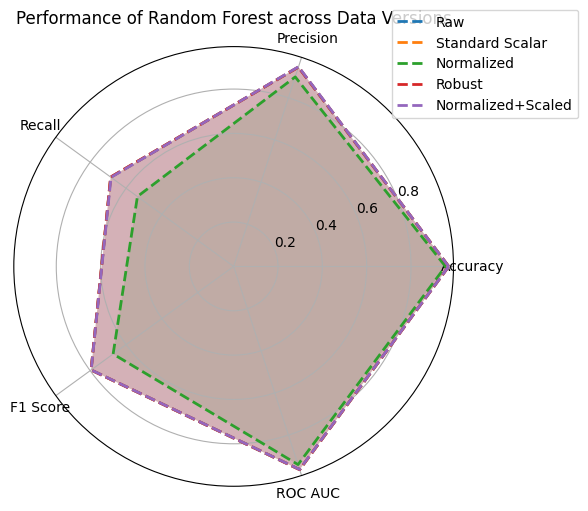

In [ ]:
model_name = "Random Forest"
df_subset = performance_df[performance_df["Model"] == model_name]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for version in df_subset["Data Version"].unique():
    row = df_subset[df_subset["Data Version"] == version][labels].values.flatten().tolist()
    row += row[:1]
    ax.plot(angles, row, label=version, linestyle='--', linewidth=2)
    ax.fill(angles, row, alpha=0.15)


# Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Performance of {model_name} across Data Versions")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

Plotting: Raw -> [0.97199, 0.9845264410814487, 0.6811764705882353, 0.805229121757875, 0.9791187952426873, 0.97199]
Plotting: Standard Scalar -> [0.97199, 0.9845264410814487, 0.6811764705882353, 0.805229121757875, 0.9791187245258759, 0.97199]
Plotting: Normalized -> [0.94827, 0.9497161394971614, 0.4132941176470588, 0.5759488482662514, 0.9319866949533911, 0.94827]
Plotting: Robust -> [0.97199, 0.9845264410814487, 0.6811764705882353, 0.805229121757875, 0.9791187309546769, 0.97199]
Plotting: Normalized+Scaled -> [0.96995, 0.9736252370280986, 0.6644705882352941, 0.7898748339276974, 0.9748396959177112, 0.96995]


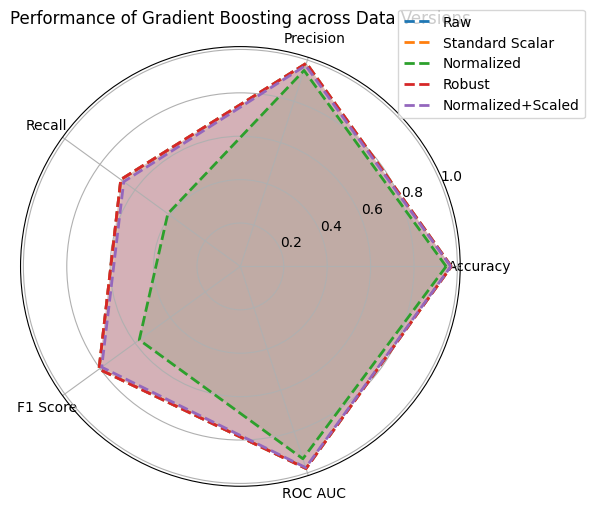

In [ ]:
model_name = "Gradient Boosting"
df_subset = performance_df[performance_df["Model"] == model_name]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for version in df_subset["Data Version"].unique():
    row = df_subset[df_subset["Data Version"] == version][labels].values.flatten().tolist()
    row += row[:1]
    ax.plot(angles, row, label=version, linestyle='--', linewidth=2)
    ax.fill(angles, row, alpha=0.15)


# Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Performance of {model_name} across Data Versions")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

Plotting: Raw -> [0.90338, 0.4522753408904222, 0.6477647058823529, 0.5326497049434071, 0.9222440970748953, 0.90338]
Plotting: Standard Scalar -> [0.90338, 0.4522753408904222, 0.6477647058823529, 0.5326497049434071, 0.9222430440372871, 0.90338]
Plotting: Normalized -> [0.87913, 0.2892231754612763, 0.28952941176470587, 0.28937621259333296, 0.7793437010607521, 0.87913]
Plotting: Robust -> [0.90338, 0.4522753408904222, 0.6477647058823529, 0.5326497049434071, 0.9222430440372871, 0.90338]
Plotting: Normalized+Scaled -> [0.8893, 0.38526785714285716, 0.5076470588235295, 0.43807106598984774, 0.9059138547090968, 0.8893]


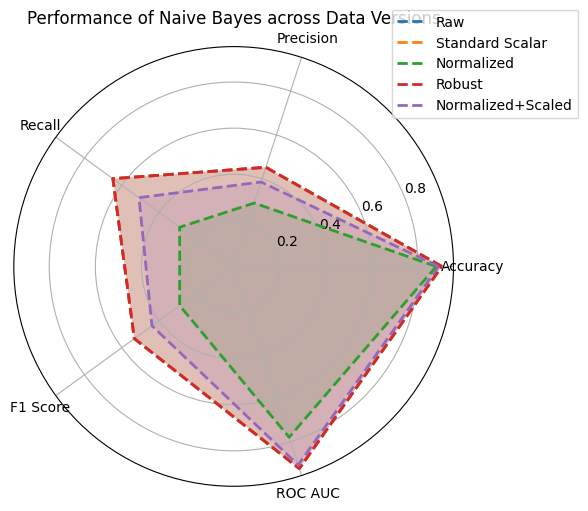

In [ ]:
model_name = "Naive Bayes"
df_subset = performance_df[performance_df["Model"] == model_name]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for version in df_subset["Data Version"].unique():
    row = df_subset[df_subset["Data Version"] == version][labels].values.flatten().tolist()
    row += row[:1]
    ax.plot(angles, row, label=version, linestyle='--', linewidth=2)
    ax.fill(angles, row, alpha=0.15)


# Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Performance of {model_name} across Data Versions")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

   Data Version     Metric     Value
2    Normalized   Accuracy  0.915000
4    Normalized   Accuracy  0.915000
8    Normalized  Precision  0.000000
10   Normalized  Precision  0.000000
14   Normalized     Recall  0.000000
16   Normalized     Recall  0.000000
20   Normalized   F1 Score  0.000000
22   Normalized   F1 Score  0.000000
26   Normalized    ROC AUC  0.744612
28   Normalized    ROC AUC  0.744612


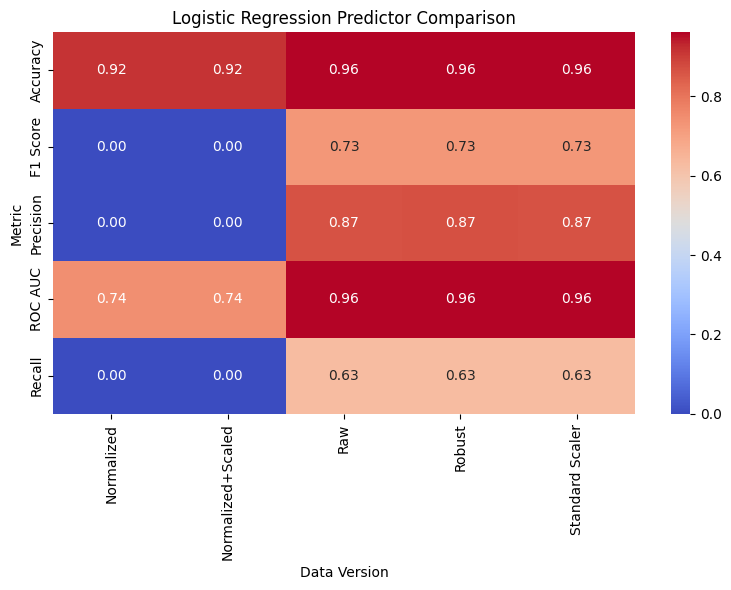

In [178]:
subset = performance_df[performance_df["Model"] == "Logistic Regression"]
metric_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

heat_data = subset.melt(
    id_vars=["Data Version"],
    value_vars=metric_cols,
    var_name="Metric",
    value_name="Value"
)
dupes = heat_data.duplicated(subset=["Metric", "Data Version"], keep=False)
print(heat_data[dupes])

heat_data_grouped = heat_data.groupby(["Metric", "Data Version"], as_index=False).mean()

pivot_data = heat_data_grouped.pivot(index="Metric", columns="Data Version", values="Value")


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Logistic Regression Predictor Comparison")
plt.ylabel("Metric")
plt.xlabel("Data Version")
plt.tight_layout()
plt.show()

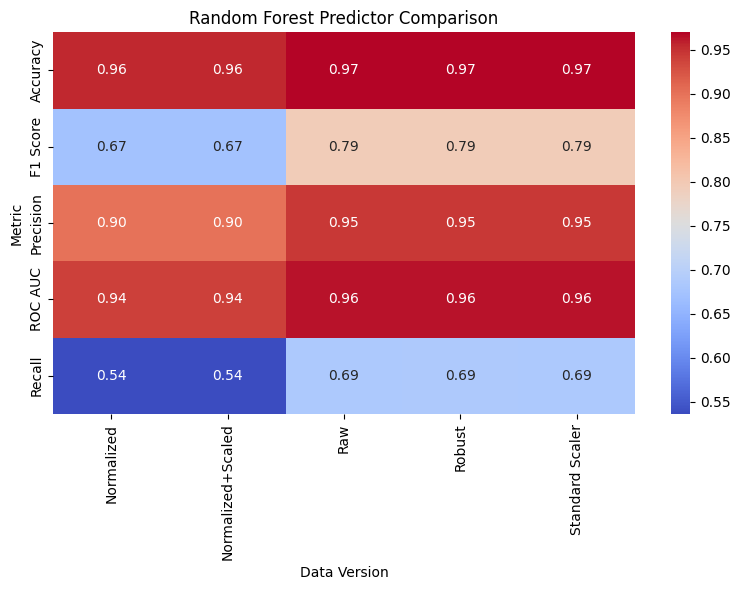

In [180]:
subset = performance_df[performance_df["Model"] == "Random Forest"]
metric_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

heat_data = subset.melt(
    id_vars=["Data Version"],
    value_vars=metric_cols,
    var_name="Metric",
    value_name="Value"
)

heat_data_grouped = heat_data.groupby(["Metric", "Data Version"], as_index=False).mean()

pivot_data = heat_data_grouped.pivot(index="Metric", columns="Data Version", values="Value")


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Random Forest Predictor Comparison")
plt.ylabel("Metric")
plt.xlabel("Data Version")
plt.tight_layout()
plt.show()

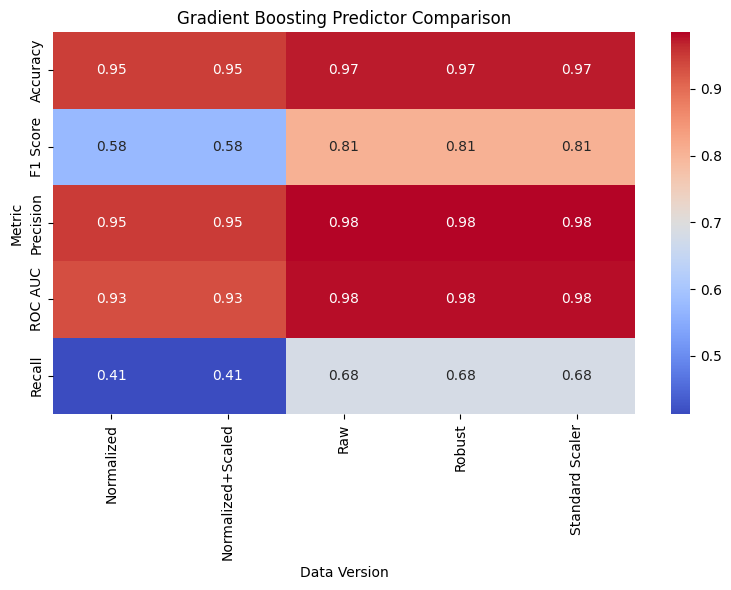

In [182]:
subset = performance_df[performance_df["Model"] == "Gradient Boosting"]
metric_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

heat_data = subset.melt(
    id_vars=["Data Version"],
    value_vars=metric_cols,
    var_name="Metric",
    value_name="Value"
)

heat_data_grouped = heat_data.groupby(["Metric", "Data Version"], as_index=False).mean()

pivot_data = heat_data_grouped.pivot(index="Metric", columns="Data Version", values="Value")


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Gradient Boosting Predictor Comparison")
plt.ylabel("Metric")
plt.xlabel("Data Version")
plt.tight_layout()
plt.show()

   Data Version     Metric     Value
2    Normalized   Accuracy  0.879130
4    Normalized   Accuracy  0.879130
8    Normalized  Precision  0.289223
10   Normalized  Precision  0.289223
14   Normalized     Recall  0.289529
16   Normalized     Recall  0.289529
20   Normalized   F1 Score  0.289376
22   Normalized   F1 Score  0.289376
26   Normalized    ROC AUC  0.779344
28   Normalized    ROC AUC  0.779344


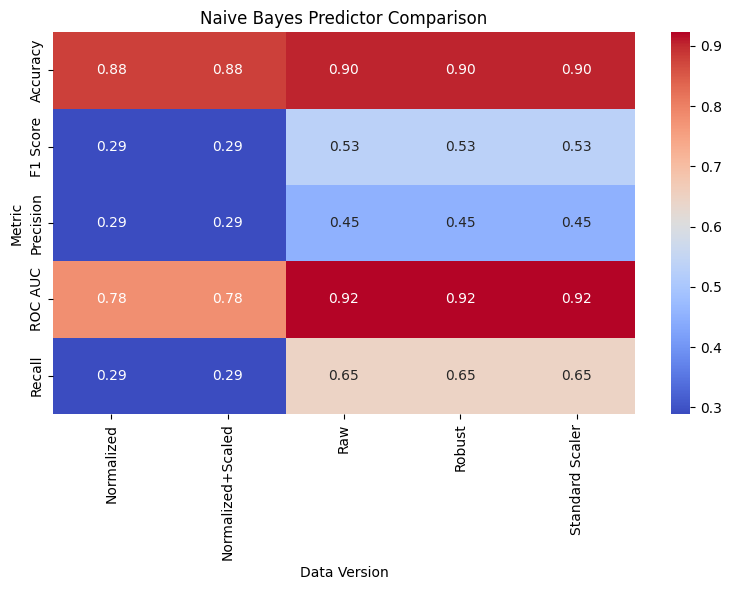

In [183]:
subset = performance_df[performance_df["Model"] == "Naive Bayes"]
metric_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

heat_data = subset.melt(
    id_vars=["Data Version"],
    value_vars=metric_cols,
    var_name="Metric",
    value_name="Value"
)

heat_data_grouped = heat_data.groupby(["Metric", "Data Version"], as_index=False).mean()

pivot_data = heat_data_grouped.pivot(index="Metric", columns="Data Version", values="Value")


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Naive Bayes Predictor Comparison")
plt.ylabel("Metric")
plt.xlabel("Data Version")
plt.tight_layout()
plt.show()